In [4]:
# 트랜스포머를 GPT-1으로 변경하기 (한국어 챗봇)

# 미션1 Transformer와 비교해 변경이 필요한 부분 서술 (compleat)


# GPT-1 챗봇 전환 작업 요약(변경 필요한 부분 서술)
1. 모델 아키텍처 변경 (Encoder-Decoder → Decoder-Only)
	-인코더(Encoder) 제거
	-DecoderLayer 수정
 		-인코더디코더어텐션과 관련 Layer Normalization(norm2)을 제거
	- Decoder 수정
		-Positional Encoding 변경

2. 데이터 처리 파이프라인 수정)
	-데이터 형식 변경: [인코더 입력, 디코더 입력, 정답] 3종류 --> [입력, 정답] 2종류로 변경
	-시퀀스 통합: 질문과 답변을 [BOS] 질문 [SEP] 답변 [EOS] 형태로 합침
3. 학습 및 추론 로직 변경
	-학습 로직(train_step): 데이터로더로부터 2개의 텐서(input_ids, label_ids)만 받도록 수정
	-모델 호출 시 model(input_ids)와 같이 1개의 인자만 전달하도록 변경

4. 주요 에러 해결 과정
	-TypeError, NameError, SyntaxError: 코드 구조 변경 과정에서 발생한 변수명 불일치, 잘못된 함수 호출, 들여쓰기 오류 등 다양한 오류 수정

# 미션2 모델의 입력 형태에 맞게 전처리를 수행 (compleat)
    -디코더 기반의 생성 모델임을 감안하여 챗봇 데이터를 변경
        >질문(Question)과 답변(Answer)을 하나의 연속된 텍스트 시퀀스로 통합 필
    -pretradindmf 위한 데이터셋과 학습만 고려함

# 미션3 모델의 입력 블록을 GPT 논문에 기반하여 수정 (compleat)
    -모델의 입력이 올바르게 구성되었는지 확인
    -데이터에 위치 정보를 추가하는 과정 구현

# 미션4 GPT 모델 전체 구성/ model.summary() (모델 구조)와 model.fit() (학습 과정) 결과를 캡처 첨부 (compleat)
    -GPT-1 모델 완성
    -증빙 자료로 첨부MQ01_modelsummary.pngMQ01_modeltrainfit.png

# 미션5 출력 생성 (compleat)
    -수준에 상관없이 정상 동작 여부 확

In [5]:
import torch
print(torch.__version__)

2.7.1+cu118


In [6]:
!pip install sentencepiece

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# 스케일드 닷 어텐션 구현

def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [9]:
# 멀티 헤드 어텐션 구현

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


In [10]:
# 패딩 마스킹

def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [11]:
# 패딩 마스크 테스트

x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)


# 두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 
#오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력합니다.
# 어텐션 연산 시에 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


In [12]:
# 룩 어헤드 마스킹

def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [13]:
# 룩 어헤드 마스크 테스트

x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [14]:
# 패딩 마스킹이 있는 경우 테스트

x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [15]:
# 디코더 레이어 구현

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # #XXX제거 두 번째 서브 레이어 (인코더-디코더 어텐션)
        # self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        # self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        #XXX 제거 self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, look_ahead_mask=None): 
        #XXX enc_outputs, padding_mask=None 도 필요없으니 제거 필요
        
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        #XXX 제거 # 2) 인코더-디코더 어텐션
        # encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        # encdec_attn_out = self.dropout2(encdec_attn_out)
        # out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        #XXX 제거 ffn_out = self.ffn(out2)
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout3(ffn_out)
        #XXX 제거 out3 = self.norm3(out2 + ffn_out) 
        out3 = self.norm3(out1 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [16]:
# GPT-style Decoder로 변경
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 max_seq_len, # 이제 이 값이 매우 중요해집니다.
                 dropout=0.1):
        super(Decoder, self).__init__()

         # d_model 값을 인스턴스 변수로 저장하여 클래스 내 다른 메서드에서 참조할 수 있도록 합니다.
        self.d_model = d_model

        # 토큰 임베딩 (변경 없음)
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (변경 1) PositionalEncoding 클래스 대신, 위치 정보를 위한 nn.Embedding 계층으로 교체
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        self.dropout = nn.Dropout(dropout)

        # DecoderLayer 쌓는 부분 (변경 없음)
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout) 
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        seq_len = x.size(1) # 입력 시퀀스의 길이를 가져옴
        
        # (변경 2) forward 로직 수정: 두 임베딩을 더하는 방식으로 변경
        
        # 위치 ID 생성 (0, 1, 2, ..., seq_len-1)
        position_ids = torch.arange(0, seq_len, dtype=torch.long, device=x.device)

        # 토큰 임베딩과 포지셔널 임베딩을 각각 계산 후 합산
        token_emb = self.embedding(x) * math.sqrt(self.d_model)
        pos_emb = self.position_embedding(position_ids)
        x = token_emb + pos_emb # 최종 입력 임베딩
        
        x = self.dropout(x)

        # 디코더 레이어 통과 (변경 없음)
        for layer in self.dec_layers:
            x = layer(x, look_ahead_mask=look_ahead_mask)
            # x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

In [17]:
# 한글에 맞는 전처리 함수 적용
def preprocess_sentence(sentence):
    # 1. 한글, 숫자, 그리고 특정 구두점을 제외한 모든 문자를 공백으로 바꿉니다.
    # 이를 통해 불필요한 특수문자나 이모티콘 등을 제거합니다.
    sentence = re.sub(r"[^?.!,ㄱ-ㅎㅏ-ㅣ가-힣0-9]+", " ", sentence)
    
    # 2. 문장 내 구두점(?, ., !, ,)과 다른 단어 사이에 공백을 추가합니다.
    # 예: "12시땡!" -> "12시땡 !" -> "12시 땡 !" (이후 단계에서 단어와 분리됨)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 3. 여러 개의 연속된 공백을 하나의 공백으로 바꿉니다.
    sentence = re.sub(r'[" "]+', " ", sentence)
        
    
    # 4. 문장의 시작과 끝에 있는 불필요한 공백을 제거합니다.
    sentence = sentence.strip()
    
    return sentence

print("check")

check


In [18]:
# 전처리 함수 테스트

sample_sentence = "12시 땡! A: 하루가 또 가네요. Q: 1지망 학교 떨어졌어 A: 위로해 드립니다. Q: 3박4일 놀러가고 싶다."

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

12시 땡 ! 하루가 또 가네요 . 1지망 학교 떨어졌어 위로해 드립니다 . 3박4일 놀러가고 싶다 .


In [19]:
# 한글 챗봇을 만들기 위한 학습 데이터 로드

import pandas as pd
import re


# 1. CSV 파일 로드
# 다운로드한 ChatbotData.csv 파일의 경로를 지정합니다.
file_path = '~/work/transformer_chatbot/data/ChatbotData.csv'
data = pd.read_csv(file_path)

# 2. 질문과 답변에 전처리 함수 적용
questions = [preprocess_sentence(q) for q in data['Q']]
answers = [preprocess_sentence(a) for a in data['A']]

# 3. (질문, 답변) 쌍으로 묶어 'pairs' 변수 생성
# 이 변수명과 형식을 유지하면 이후 코드와 호환됩니다.
pairs = list(zip(questions, answers))

# 4. 샘플 수 및 내용 확인
print('전체 샘플 수 :', len(pairs))
print("\n--- 5개 샘플 ---")
for q, a in pairs[:5]:
    print(f"Q: {q}")
    print(f"A: {a}\n")

전체 샘플 수 : 11823

--- 5개 샘플 ---
Q: 12시 땡 !
A: 하루가 또 가네요 .

Q: 1지망 학교 떨어졌어
A: 위로해 드립니다 .

Q: 3박4일 놀러가고 싶다
A: 여행은 언제나 좋죠 .

Q: 3박4일 정도 놀러가고 싶다
A: 여행은 언제나 좋죠 .

Q: 심하네
A: 눈살이 찌푸려지죠 .



In [20]:
# Tokenizer 학습하기

In [21]:
# pair를 텍스트 파일에 저장

corpus_file = "clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
         # <SEP> 토큰을 사용해 질문과 답변을 한 문장으로 취급하도록 함
        combined_sentence = q + " <SEP> " + a
        f.write(combined_sentence + "\n")
        
        # f.write(q + "\n")
        # f.write(a + "\n")

In [22]:
# 질문-답변 쌍이 담긴 clean_corpus.txt 파일을 이용해 SentencePiece 모델을 훈련하고, 
# 토크나이저가 담길 model / vocab 파일을 생성하겠습니다.

# SentencePiece BPE 토크나이저 훈련
# 텍스트 파일(corpus_file)을 입력받아 BPE 알고리즘을 기반으로
# 단어 사전(.vocab)과 토큰화 모델(.model)을 생성합니다.
spm.SentencePieceTrainer.Train(
    # input: 토크나이저 훈련에 사용할 원본 텍스트 파일의 경로를 지정합니다.
    # 이 파일의 내용을 기반으로 단어 사전을 구축합니다.
    input=corpus_file,

    # model_prefix: 훈련 후 생성될 모델 파일과 단어 사전 파일의 이름 접두사를 설정합니다.
    # 실행 결과로 'spm_songys.model'과 'spm_songys.vocab' 파일이 생성됩니다.
    model_prefix="spm_songys",

    # vocab_size: 생성할 단어 사전(vocabulary)의 크기를 지정합니다.
    # BPE 알고리즘이 8,000개의 서브워드(subword) 토큰을 만들 때까지 병합을 반복합니다.
    vocab_size=8000,

    # character_coverage: 훈련 데이터의 문자(character) 중 어느 정도를 커버할지 결정합니다.
    # 1.0은 100%를 의미하며, 모든 문자를 포함하여 단어 사전을 구성하도록 합니다.
    character_coverage=1.0,

    # model_type: 사용할 토큰화 알고리즘의 종류를 선택합니다.
    # 'bpe'는 가장 빈번하게 등장하는 문자 쌍을 병합해 나가는 Byte Pair Encoding 방식을 의미합니다.
    model_type="bpe",

    # max_sentence_length: 학습 시 처리할 문장의 최대 길이를 바이트 단위로 지정합니다.
    # 매우 큰 값(999999)을 설정하여 사실상 길이 제한 없이 모든 문장을 학습에 사용합니다.
    max_sentence_length=999999,

    # bos_id: 문장의 시작을 알리는 BOS(Beginning of Sentence) 토큰 '<s>'의 ID를 1로 설정합니다.
    bos_id=1,

    # eos_id: 문장의 끝을 알리는 EOS(End of Sentence) 토큰 '</s>'의 ID를 2로 설정합니다.
    eos_id=2,

    # pad_id: 문장 길이를 맞추기 위한 패딩(Padding) 토큰 '<pad>'의 ID를 0으로 설정합니다.
    pad_id=0,

    # unk_id: 단어 사전에 없는 단어를 처리하기 위한 UNK(Unknown) 토큰 '<unk>'의 ID를 3으로 설정합니다.
    unk_id=3,

    #우리가 직접 추가한 토큰을 spm에 알려주는 옵션
    user_defined_symbols='<SEP>'
)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus.txt
  input_format: 
  model_prefix: spm_songys
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <SEP>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_dif

In [23]:
# 학습시킨 토크나이저를 불러와 테스트

sp = spm.SentencePieceProcessor()
sp.Load("spm_songys.model")

True

In [24]:
# 문장 테스트
sentence = "SNS 시간낭비인데 자꾸 보게됨!! 시간을 정하고 해보세요. SentencePiece!"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 시간낭비인데 자꾸 보게됨 ! ! 시간을 정하고 해보세요 . !
Tokenized: ['▁시간', '낭', '비', '인데', '▁자꾸', '▁보게', '됨', '▁!', '▁!', '▁시간을', '▁정', '하고', '▁해보세요', '▁.', '▁!']
Encoded: [90, 7389, 6897, 213, 264, 3678, 7409, 109, 109, 771, 68, 71, 170, 5, 109]
Decoded: 시간낭비인데 자꾸 보게됨 ! ! 시간을 정하고 해보세요 . !


최대 길이: 43
평균 길이: 14.18
95% percentile: 21.00
99% percentile: 26.00


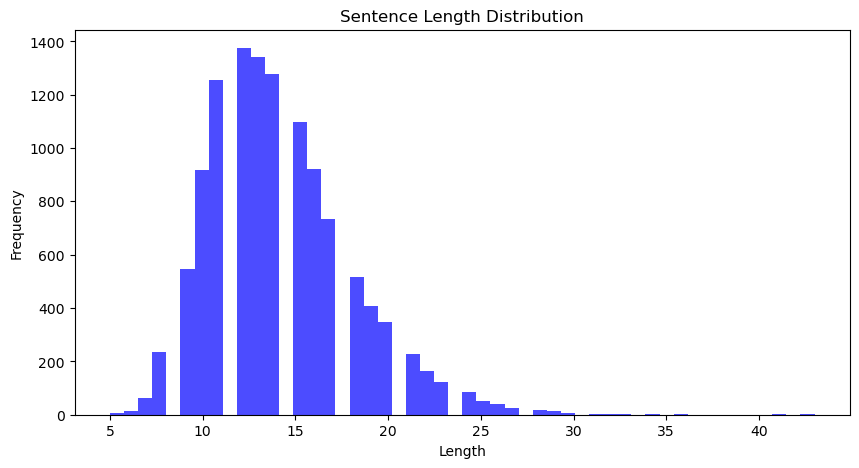

In [25]:
# 데이터 길이등 구성 확인

import numpy as np
import matplotlib.pyplot as plt

# SentencePiece 모델이 'sp'라는 변수로 로드되었다고 가정합니다.

#XXX 제거 # 모든 질문과 답변의 토큰 길이를 저장할 리스트
# q_lengths = []
# a_lengths = []

# for q, a in pairs:
#     # BOS, EOS 토큰을 포함한 길이를 계산하기 위해 +2를 해줍니다.
#     q_lengths.append(len(sp.encode(q)) + 2)
#     a_lengths.append(len(sp.encode(a)) + 2)

# # 질문과 답변 길이를 합쳐 전체 분포를 확인
# all_lengths = q_lengths + a_lengths

# (수정) 합쳐진 문장의 길이를 분석
combined_lengths = []
# <SEP> 토큰의 ID를 4로 가정 (사용자 정의 토큰)
for q, a in pairs:
    # len(q) + len(a) + 3 (BOS, SEP, EOS)
    combined_len = len(sp.encode(q)) + len(sp.encode(a)) + 3 
    combined_lengths.append(combined_len)


# --- 통계 분석 ---
print(f"최대 길이: {np.max(combined_lengths)}")
print(f"평균 길이: {np.mean(combined_lengths):.2f}")
print(f"95% percentile: {np.percentile(combined_lengths, 95):.2f}")
print(f"99% percentile: {np.percentile(combined_lengths, 99):.2f}")


# --- 시각화 ---
plt.figure(figsize=(10, 5))
plt.hist(combined_lengths, bins=50, alpha=0.7, color='blue')
plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [26]:
# GPT 모델에 맞는 Dataset 클래스

class GptDataset(Dataset):
    def __init__(self, pairs, sp, max_length=44):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        unk_id = self.sp.unk_id()
        # <SEP> 토큰을 ID로 변환 시도합니다.
        sep_id = self.sp.piece_to_id('<SEP>')
        
        # 만약 변환된 ID가 <unk> 토큰 ID와 같다면, 단어장에 <SEP>이 없다는 의미입니다.
        if sep_id == unk_id:
    # 이 경우, 사전에 정의한 대체 ID(4)를 사용합니다.
            print("Warning: '<SEP>' 토큰이 단어장에 없습니다. ID를 4로 설정합니다.")
            sep_id = 4
        
        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            bos_id = sp.bos_id()
            eos_id = sp.eos_id()

            # 2) (핵심) 질문과 답변을 하나의 시퀀스로 통합
            combined_ids = [bos_id] + q_ids + [sep_id] + a_ids + [eos_id]

            # 시퀀스가 max_length보다 길면 잘라냅니다.
            combined_ids = combined_ids[:max_length]

            # 3) 통합된 시퀀스의 길이 제한
            if len(combined_ids) > max_length:
                continue

            # 4) 패딩
            padding = [0] * (max_length - len(combined_ids))
            combined_ids.extend(padding)

            # 5) 입력과 정답 생성
            # 입력: 마지막 토큰 제외
            input_ids = combined_ids[:-1]
            # 정답: 첫 토큰 제외
            label_ids = combined_ids[1:]
            
            self.data.append({
                "input_ids": input_ids,
                "label_ids": label_ids
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        input_ids = torch.tensor(sample["input_ids"], dtype=torch.long)
        label_ids = torch.tensor(sample["label_ids"], dtype=torch.long)
        # (수정) GPT 모델에 맞는 두 개의 텐서만 반환
        return input_ids, label_ids

In [27]:
dataset = GptDataset(pairs, sp, max_length=44)

In [28]:
# 데이터셋 샘플 확인
# for문 변수를 dataset이 반환하는 2개(input_ids, label_ids)에 맞게 수정
for input_ids, label_ids in dataset:
    # print("-텐서 크기 :",encoder_input.size()) # 변수명이 바뀌었으므로 수정
    print("-텐서 크기 :", input_ids.size())
    print("--------------------------------")
    
    # encoder_input -> input_ids 로 변수명 변경
    print("-input_ids: ", input_ids)
    print(sp.decode(input_ids.tolist()))
    print("--------------------------------")
    
    # decoder_input은 GPT 데이터셋에 없으므로 관련 코드 제거
    
    # decoder_label -> label_ids 로 변수명 변경
    print("-label_ids:", label_ids)
    print(sp.decode(label_ids.tolist()))
    break


-텐서 크기 : torch.Size([43])
--------------------------------
-input_ids:  tensor([   1, 5555, 6825, 3203,  109,    4, 4485,  215, 5922,    5,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0])
12시 땡 !<SEP> 하루가 또 가네요 .
--------------------------------
-label_ids: tensor([5555, 6825, 3203,  109,    4, 4485,  215, 5922,    5,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0])
12시 땡 !<SEP> 하루가 또 가네요 .


In [29]:
# DataLoader 구성하기

dataloader = DataLoader(dataset,batch_size=64,shuffle=True)

In [30]:
# 데이터셋이 반환하는 두 개의 값(입력, 정답)만 받도록 수정
for input_ids, label_ids in dataloader:
    print("Input Batch Shape:", input_ids.size())  # 예: torch.Size([64, 39])
    print("Label Batch Shape:", label_ids.size())  # 예: torch.Size([64, 39])
    break

Input Batch Shape: torch.Size([64, 43])
Label Batch Shape: torch.Size([64, 43])


In [31]:
# 모델 정의하기
#  트랜스포머 함수를 GPT-1 모델로 수정 정의합니다.

class GPT_1(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 max_seq_len,
                 dropout=0.1
                 ):
        super(GPT_1, self).__init__()


        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            max_seq_len=max_seq_len
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)


    def forward(self, inputs): #입력을 하나만 받도록 변경

        # 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)
        padding_mask = create_padding_mask(inputs)
        combined_mask = torch.max(look_ahead_mask, padding_mask)

        # 디코더 수행
        dec_outputs = self.decoder(
            x=inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=None,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=None
        )

        # 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [32]:
#  모델 생성
    
#  하이퍼파라미터 설정
NUM_LAYERS = 12     # GPT 모델에 맞춰 12 설정
D_MODEL = 512      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512       # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)
MAX_SEQ_LEN = 44

# 모델 생성
model = GPT_1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_seq_len=MAX_SEQ_LEN   
)

print(model)


GPT_1(
  (decoder): Decoder(
    (embedding): Embedding(8000, 512)
    (position_embedding): Embedding(44, 512)
    (dropout): Dropout(p=0.1, inplace=False)
    (dec_layers): ModuleList(
      (0-11): 12 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, bias=True)
          (out_dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm3): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout3): Dropout(p=0.1, 

In [33]:
# 손실 함수(Loss function)

loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [35]:
#학습률(Learning rate) 커스텀

# Transformer를 위한 커스텀 학습률 스케줄러 함수 생성
def get_lr_lambda(d_model, warmup_steps=4000):

     # d_model을 부동소수점 숫자로 변환하여 계산에 사용합니다.
    d_model = float(d_model)

     # PyTorch의 LambdaLR 스케줄러에 전달될 실제 함수를 정의합니다.
    def lr_lambda(step):
         # PyTorch 스케줄러의 step은 0부터 시작하지만, 논문의 수식은 1부터 시작하므로
         # step 값에 1을 더하여 보정해줍니다.
        step = step + 1
        
        # min() 함수를 통해 warmup 단계와 decay 단계를 구분합니다.
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
        

     #  스텝별 학습률 배율을 계산하는 함수를 반환합니다.
    return lr_lambda

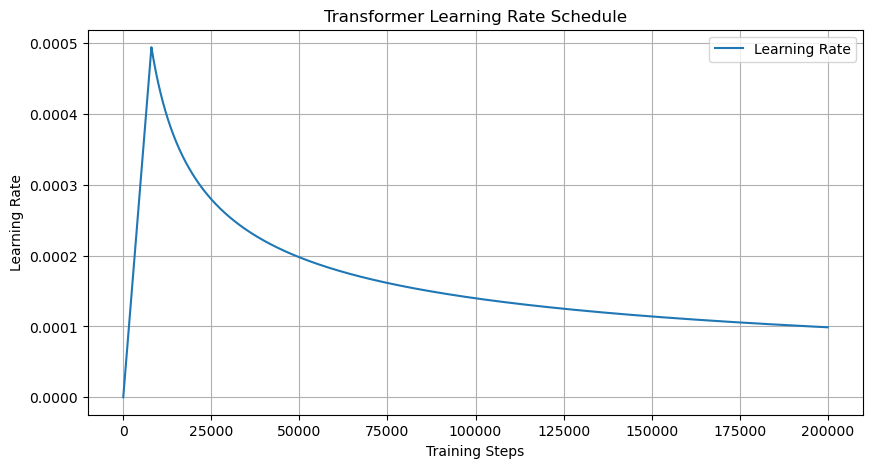

In [36]:
# 정의한 커스텀 학습률 스케줄링 계획을 시각화

# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 8000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# 모델 컴파일
# 손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

# Adam 옵티마이저를 정의합니다. 초기 lr은 스케줄러가 매 스텝마다 덮어쓰므로 중요하지 않습니다.
optimizer = optim.Adam(model.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9)

# 위에서 정의한 get_lr_lambda 함수를 사용하여 스케줄러를 생성합니다.
# warmup_steps는 데이터셋 크기와 배치 크기에 따라 조정이 필요한 중요한 하이퍼파라미터입니다. (예: 4000)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):

    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [39]:
#  훈련하기

def train_step(model, batch, optimizer, loss_function, device):
    model.train()
        # 1. (수정) 2개의 텐서(입력, 정답)를 받습니다.
    input_ids, label_ids = [x.to(device) for x in batch]
   
    #enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    # 2. (수정) 모델을 1개의 인자로 호출합니다.
    logits = model(input_ids)
    #logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

        # Loss 계산 (logits의 차원과 target의 변수명만 수정)
    loss = loss_function(logits.permute(0, 2, 1), label_ids)
    # loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # 정확도 계산 (target 변수명 수정)
    acc = accuracy_function(logits, label_ids, pad_id=sp.pad_id())
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, label_ids, pad_id=sp.pad_id())

In [41]:
import time

def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)
    history = [] # 에포크별 결과를 저장할 리스트

    print("훈련을 시작합니다...")
    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss, total_acc = 0, 0

        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            scheduler.step()
            total_loss += loss
            total_acc += acc
            
            # 100 스텝마다 현재 상태 출력 (실시간 모니터링용)
            if step % 100 == 0 and step > 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        end_time = time.time()
        
        # 에포크 종료 로그 생성
        epoch_log = (f"Epoch {epoch+1}/{num_epochs} | "
                     f"Avg Loss: {avg_loss:.4f} | "
                     f"Avg Acc: {avg_acc:.4f} | "
                     f"Time: {end_time - start_time:.2f}s")
        
        print(epoch_log) # 화면에 에포크 결과 출력
        history.append(epoch_log) # 리스트에 결과 저장
    
    print("훈련이 종료되었습니다.")
    return history

# 훈련 실행 및 결과 저장
training_history = train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25,
    device=device
)

# 훈련 로그를 텍스트 파일로 저장합니다.
with open("training_log.txt", "w", encoding="utf-8") as f:
    for log_line in training_history:
        f.write(log_line + "\n")

print("\n'training_log.txt' 파일이 성공적으로 저장되었습니다.")

훈련을 시작합니다...
[Epoch 1, Step 100] Loss: 6.3755, Acc: 0.2247
Epoch 1/25 | Avg Loss: 6.4545 | Avg Acc: 0.2304 | Time: 27.66s
[Epoch 2, Step 100] Loss: 6.0327, Acc: 0.2382
Epoch 2/25 | Avg Loss: 6.0173 | Avg Acc: 0.2424 | Time: 28.85s
[Epoch 3, Step 100] Loss: 5.7716, Acc: 0.2570
Epoch 3/25 | Avg Loss: 5.6773 | Avg Acc: 0.2574 | Time: 27.88s
[Epoch 4, Step 100] Loss: 5.3830, Acc: 0.2537
Epoch 4/25 | Avg Loss: 5.3434 | Avg Acc: 0.2729 | Time: 27.84s
[Epoch 5, Step 100] Loss: 5.1176, Acc: 0.2663
Epoch 5/25 | Avg Loss: 5.0028 | Avg Acc: 0.2909 | Time: 28.24s
[Epoch 6, Step 100] Loss: 4.7520, Acc: 0.3085
Epoch 6/25 | Avg Loss: 4.6513 | Avg Acc: 0.3140 | Time: 28.15s
[Epoch 7, Step 100] Loss: 4.3205, Acc: 0.3321
Epoch 7/25 | Avg Loss: 4.2842 | Avg Acc: 0.3416 | Time: 28.06s
[Epoch 8, Step 100] Loss: 3.9240, Acc: 0.3695
Epoch 8/25 | Avg Loss: 3.9041 | Avg Acc: 0.3751 | Time: 27.99s
[Epoch 9, Step 100] Loss: 3.6306, Acc: 0.3923
Epoch 9/25 | Avg Loss: 3.5140 | Avg Acc: 0.4173 | Time: 28.00s
[Epoch

In [ ]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25,  
    device=device
)

In [ ]:
# 챗봇 테스트하기

In [42]:
# GPT 모델을 위한 올바른 추론 함수
def decoder_inference(model, sentence, tokenizer, device='cpu', max_length=44):
    model.eval() # 모델을 평가 모드로 설정
    
    # 특수 토큰 ID 가져오기
    bos_id = tokenizer.bos_id()
    eos_id = tokenizer.eos_id()
    # <SEP> 토큰 ID를 4로 가정 (SentencePiece 훈련 시 설정한 값)
    unk_id = tokenizer.unk_id()
    sep_id = tokenizer.piece_to_id('<SEP>') 
    if sep_id == unk_id:
        print("Warning: '<SEP>' 토큰이 단어장에 없어 ID 4를 사용합니다.")
        sep_id = 4  # 단어장에 없으면 ID 4로 가정 

    # 1. (수정) 입력 문장을 전처리하고, GPT 입력 형식에 맞게 프롬프트를 생성
    #    형식: [BOS] + 질문 + [SEP]
    prompt_ids = [bos_id] + tokenizer.encode(preprocess_sentence(sentence)) + [sep_id]
    
    # 2. (수정) 프롬프트를 텐서로 변환. 이제 이것이 유일한 입력(input_ids)임
    input_ids = torch.tensor([prompt_ids], dtype=torch.long, device=device)

    with torch.no_grad():
        for i in range(max_length):
            model_input = input_ids[:, -max_length:]

            # [디버깅 코드] 모델에 들어가는 입력의 정보를 출력합니다.
           # print(f"Step: {i+1}, Input Shape: {model_input.shape}, Max ID: {model_input.max().item()}")


                        
            # 3. (수정) 전체 시퀀스를 모델의 입력으로 전달
            logits = model(model_input) # input_ids -> model_input 으로 변경
            #logits = model(input_ids) # model(enc_input, dec_input) -> model(input_ids)

            # 마지막 토큰의 로짓만 사용
            last_step_logits = logits[:, -1, :]
            
            # 가장 확률이 높은 토큰 ID 예측
            predicted_id = torch.argmax(last_step_logits, dim=-1).unsqueeze(0)

            # 4. (수정) 예측된 토큰을 기존 시퀀스에 이어붙여 다음 입력으로 사용
            input_ids = torch.cat([input_ids, predicted_id], dim=1)

            # 만약 예측된 토큰이 [EOS]라면 생성을 중단
            if predicted_id.item() == eos_id:
                break
    
    # 최종 생성된 시퀀스 반환 (프롬프트 부분은 제외하고 답변만 반환할 수도 있음)
    return input_ids.squeeze(0).tolist()

In [47]:
# 문장 생성기(sentence_generation) 함수 만들기
 # 임의의 입력 문장에 대한 decoder_inference 함수 호출 

def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # <SEP> 토큰의 ID를 가져옵니다.
    sep_id = tokenizer.piece_to_id('<SEP>')

    # 생성된 토큰 시퀀스(output_seq)에서 <SEP> 토큰의 위치(인덱스)를 찾습니다.
    try:
        sep_index = output_seq.index(sep_id)
        # <SEP> 토큰 바로 다음 위치부터 끝까지를 답변 부분으로 잘라냅니다.
        answer_tokens = output_seq[sep_index + 1:]
    except ValueError:
        # 만약 <SEP> 토큰이 생성되지 않았을 경우, 전체를 답변으로 간주합니다.
        answer_tokens = output_seq

    # 잘라낸 답변 부분의 토큰들만 문장으로 복원(디코딩)합니다.
    predicted_sentence = tokenizer.decode(
        [token for token in answer_tokens if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [48]:
#★★★★★ 챗봇 테스트

sentence = '안녕하세요'
sentence_generation(model, sentence, sp, device)

입력 : 안녕하세요
출력 : 안녕하세요 .


'안녕하세요 .'

In [49]:
#★★★★★ 챗봇 테스트
sentence = "12시에 만나요"
sentence_generation(model, sentence, sp, device)

입력 : 12시에 만나요
출력 : 하루가 또 가네요 .


'하루가 또 가네요 .'

In [50]:
#★★★★★ 챗봇 테스트
sentence = "가끔 궁금해"
sentence_generation(model, sentence, sp, device)

입력 : 가끔 궁금해
출력 : 그 사람도 그럴 거예요 .


'그 사람도 그럴 거예요 .'

In [51]:
#★★★★★ 챗봇 테스트
sentence = "가족은 어떤 사이일까?"
sentence_generation(model, sentence, sp, device)

입력 : 가족은 어떤 사이일까?
출력 : 더 가까워질 기회가 되겠네요 .


'더 가까워질 기회가 되겠네요 .'

In [52]:
#★★★★★ 챗봇 테스트
sentence = "잠을 못자서 피곤하다"
sentence_generation(model, sentence, sp, device)

입력 : 잠을 못자서 피곤하다
출력 : 잠이 최고의 보약이에요 . 노력해보세요 .


'잠이 최고의 보약이에요 . 노력해보세요 .'

In [53]:
#★★★★★ 챗봇 테스트
sentence = "너는 혈액형이 뭐니?"
sentence_generation(model, sentence, sp, device)

입력 : 너는 혈액형이 뭐니?
출력 : 저는 자장면이 있을 거예요 .


'저는 자장면이 있을 거예요 .'

In [54]:
#★★★★★ 챗봇 테스트
sentence = "수영이 도움이 될까?"
sentence_generation(model, sentence, sp, device)

입력 : 수영이 도움이 될까?
출력 : 기본으로 배워 놓는 게 좋죠 .


'기본으로 배워 놓는 게 좋죠 .'

In [55]:
!pip install torchinfo

In [57]:
import torch  # torch.long을 사용하기 위해 import
from torchinfo import summary

# 이전에 정의한 모델 객체를 사용합니다.
# model = GPT_1(...) 

# 모델에 들어갈 입력 데이터의 형태를 정의합니다. (배치 크기, 최대 시퀀스 길이)
# 배치 크기는 보통 1로 설정하여 요약을 생성합니다.
input_shape = (1, MAX_SEQ_LEN) 

# torchinfo.summary를 사용하여 모델 요약 객체를 생성합니다.
# verbose=0으로 설정하면 바로 출력하지 않고 객체만 반환받을 수 있습니다.
model_summary = summary(model, 
                        input_size=input_shape, 
                        dtypes=[torch.long],
                        verbose=0) # 중요: 결과를 변수에 저장하기 위해 verbose=0 설정

# 생성된 요약 정보를 화면에 출력합니다.
print(model_summary)

# 요약 정보를 텍스트 파일로 저장합니다.
with open("model_summary.txt", "w", encoding="utf-8") as f:
    f.write(str(model_summary))

print("\n'model_summary.txt' 파일이 성공적으로 저장되었습니다.")

Layer (type:depth-idx)                        Output Shape              Param #
GPT_1                                         [1, 44, 8000]             --
├─Decoder: 1-1                                [1, 44, 512]              --
│    └─Embedding: 2-1                         [1, 44, 512]              4,096,000
│    └─Embedding: 2-2                         [44, 512]                 22,528
│    └─Dropout: 2-3                           [1, 44, 512]              --
│    └─ModuleList: 2-4                        --                        --
│    │    └─DecoderLayer: 3-1                 [1, 44, 512]              1,577,984
│    │    └─DecoderLayer: 3-2                 [1, 44, 512]              1,577,984
│    │    └─DecoderLayer: 3-3                 [1, 44, 512]              1,577,984
│    │    └─DecoderLayer: 3-4                 [1, 44, 512]              1,577,984
│    │    └─DecoderLayer: 3-5                 [1, 44, 512]              1,577,984
│    │    └─DecoderLayer: 3-6                 [1,